# TO-DO:
- Add info on Nasdaq trading (theory for every column)
- Nulls
- Outliers (detect columns first)

# Goal

In this competition, you are challenged to develop a model capable of predicting the closing price movements for hundreds of Nasdaq listed stocks using data from the order book and the closing auction of the stock. Information from the auction can be used to adjust prices, assess supply and demand dynamics, and identify trading opportunity.

Stock exchanges are fast-paced, high-stakes environments where every second counts. The intensity escalates as the trading day approaches its end, peaking in the critical final ten minutes. These moments, often characterised by heightened volatility and rapid price fluctuations, play a pivotal role in shaping the global economic narrative for the day.

Each trading day on the Nasdaq Stock Exchange concludes with the Nasdaq Closing Cross auction. This process establishes the official closing prices for securities listed on the exchange. These closing prices serve as key indicators for investors, analysts and other market participants in evaluating the performance of individual securities and the market as a whole.

Within this complex financial landscape operates Optiver, a leading global electronic market maker. Fueled by technological innovation, Optiver trades a vast array of financial instruments, such as derivatives, cash equities, ETFs, bonds, and foreign currencies, offering competitive, two-sided prices for thousands of these instruments on major exchanges worldwide.

In the last ten minutes of the Nasdaq exchange trading session, market makers like Optiver merge traditional order book data with auction book data. This ability to consolidate information from both sources is critical for providing the best prices to all market participants.

In this competition, you are challenged to develop a model capable of predicting the closing price movements for hundreds of Nasdaq listed stocks using data from the order book and the closing auction of the stock. Information from the auction can be used to adjust prices, assess supply and demand dynamics, and identify trading opportunities.

Your model can contribute to the consolidation of signals from the auction and order book, leading to improved market efficiency and accessibility, particularly during the intense final ten minutes of trading. You'll also get firsthand experience in handling real-world data science problems, similar to those faced by traders, quantitative researchers and engineers at Optiver.


# Description of the Files
- [train/test].csv - the auction data
- sample_submission - a valid sample submission
- revealed_targets - when the first time_id for each date (i.e. when seconds_in_bucket equals zero) the API will serve a dataframe providing the true target values for the entire previous date. All other rows contain null values for the columns of interest.
- public_timeseries_testing_util.py - an optional file intended to make it easier to run custom offline API tests. See the script's docstring for details. You will need to edit this file before using it.
- example_test_files/ - data intended to illustrate how the API functions. Includes the same files and columns delivered by the API. The first three date ids are repeats of the last three date ids in the train set, to enable an illustration of how the API functions.
- optiver2023/ - files that enable the API. Expect the API to deliver all rows in under five minutes and to reserve less than 0.5 GB of memory. The first three date ids delivered by the API are repeats of the last three date ids in the train set, to better illustrate how the API functions. You must make predictions for those dates in order to advance the API but those predictions are not scored.

# Target Metric
$$\text{MAE} = \dfrac{1}{n} \sum^n_{i=1} |y_i - x_i|,$$
where:
- $n$ is the total number of data points.
- $y_i$ is the predicted value for data point $i$.
- $x_i$ is the observed value for data point $i$.


# Imports

In [5]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython import display
warnings.filterwarnings('ignore')

# Data Preprocessing and EDA

In [7]:
df = pd.read_csv('Optiver Trading Close/train.csv')
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')
df.head(5)

Number of rows: 5237980
Number of columns: 17


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


Columns:
- stock_id - A unique identifier for the stock. Not all stock IDs exist in every time bucket.
- date_id - A unique identifier for the date. Date IDs are sequential & consistent across all stocks.
- imbalance_size - The amount unmatched at the current reference price (in USD).
- imbalance_buy_sell_flag - An indicator reflecting the direction of auction imbalance.
- - buy-side imbalance; 1
- - sell-side imbalance; -1
- - no imbalance; 0
- reference_price - The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.
- matched_size - The amount that can be matched at the current reference price (in USD).
- far_price - The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.
- near_price - The crossing price that will maximize the number of shares matched based auction and continuous market orders.
- [bid/ask]_price - Price of the most competitive buy/sell level in the non-auction book.
- [bid/ask]_size - The dollar notional amount on the most competitive buy/sell level in the non-auction book.
- wap - The weighted average price in the non-auction book.
$$\text{WAP} = \dfrac{BidPrice \cdot AskSize + AskPrice \cdot BidPrice}{BidSize + AskSize}$$
- seconds_in_bucket - The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.
- target - The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index. Only provided for the train set.
- - The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition.
- - The unit of the target is basis points, which is a common unit of measurement in financial markets. A 1 basis point price move is equivalent to a 0.01% price move.
- - Where $t$ is the time at the current observation, we can define the target:

$$\text{Target} = \left( \dfrac{StockWAP_{t+60}}{StockWAP_t} - \dfrac{IndexWAP_{t+60}}{IndexWAP_t} \right) \cdot 10000$$

In [18]:
# Check Null values
null_info = pd.DataFrame(df.isna().sum().sort_values(ascending=False))
null_info.columns = ['Num of Nulls']
null_info['Share of Nulls'] = round(null_info['Num of Nulls'] / df.shape[0], 2)

null_info

,Num of Nulls,Share of Nulls
far_price,2894342,0.55
near_price,2857180,0.55
ask_price,220,0.00
imbalance_size,220,0.00
reference_price,220,0.00
matched_size,220,0.00
wap,220,0.00
bid_price,220,0.00
target,88,0.00
time_id,0,0.00


In [20]:
df.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


In [39]:
print(f'Number of unique stocks: {df.stock_id.nunique()}')
print(f'Min date id: {df.date_id.min()}')
print(f'Max date id: {df.date_id.max()}')
print(f'Date interval: {df.date_id.max() - df.date_id.min()}')

Number of unique stocks: 200
Min date id: 0
Max date id: 480
Date interval: 480


In [29]:
COLOR = 'cornflowerblue'

numerical_cols = ['imbalance_size', 'reference_price', 'matched_size', 
                  'far_price', 'near_price', 'bid_price', 'ask_price', 
                  'bid_size', 'ask_size', 'wap', 'seconds_in_bucket', 'target']

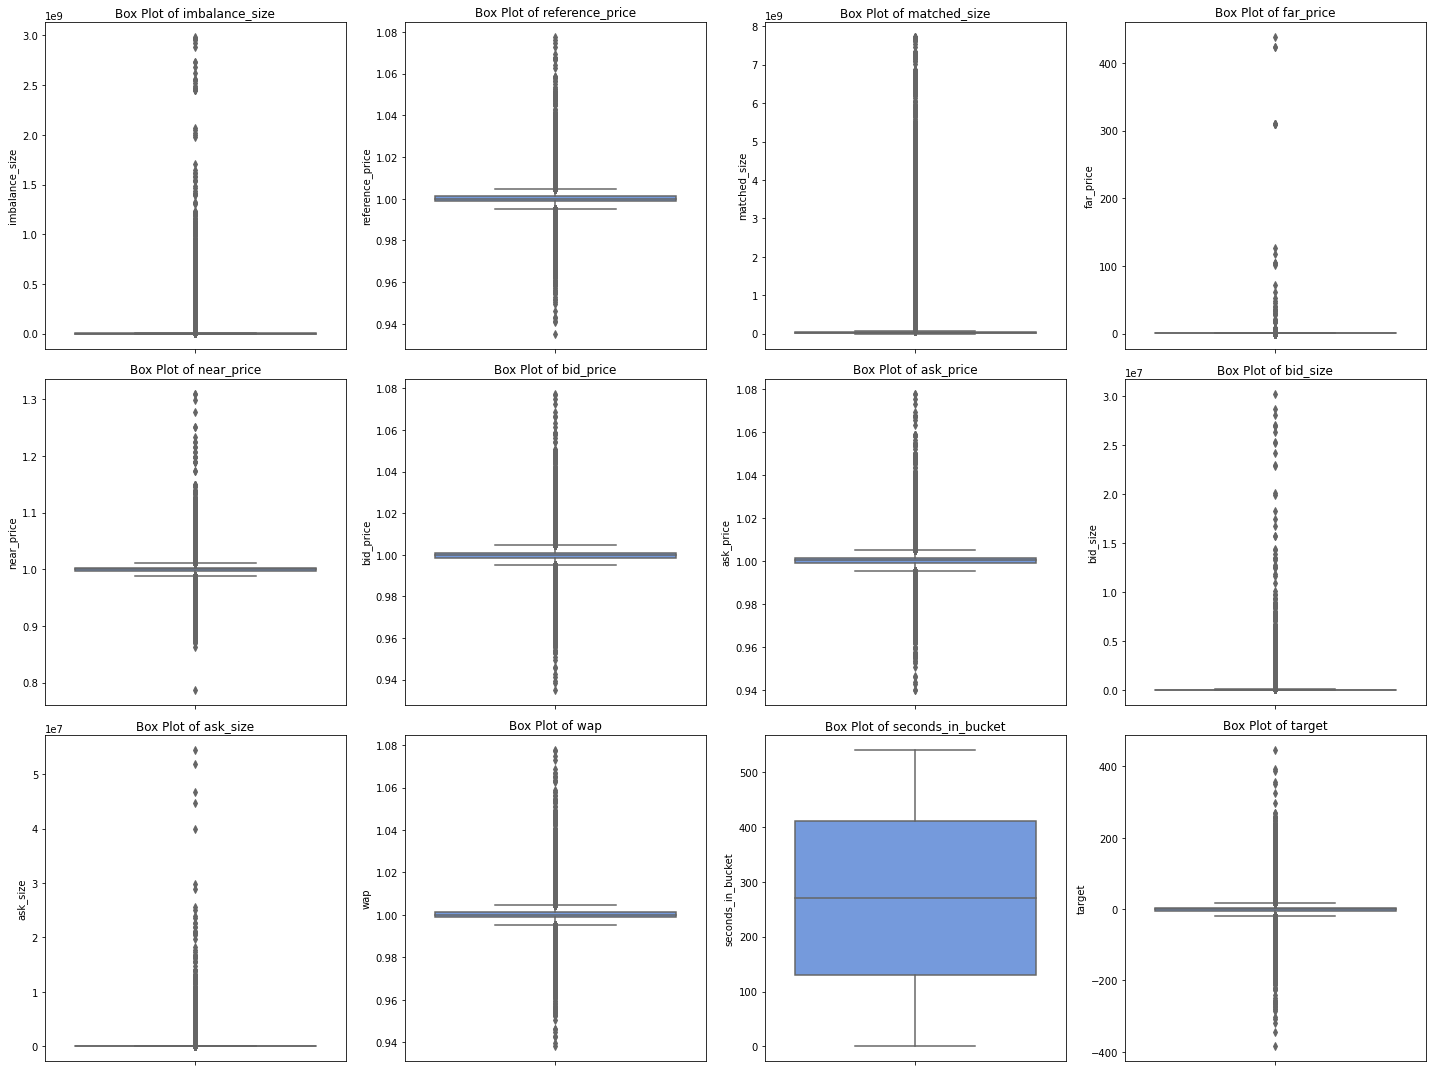

In [30]:
# Box Plots
n_cols = 4
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for i, var in enumerate(numerical_cols):
    sns.boxplot(data=df, y=var, color=COLOR, ax=axes[i])
    axes[i].set_title(f'Box Plot of {var}')
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

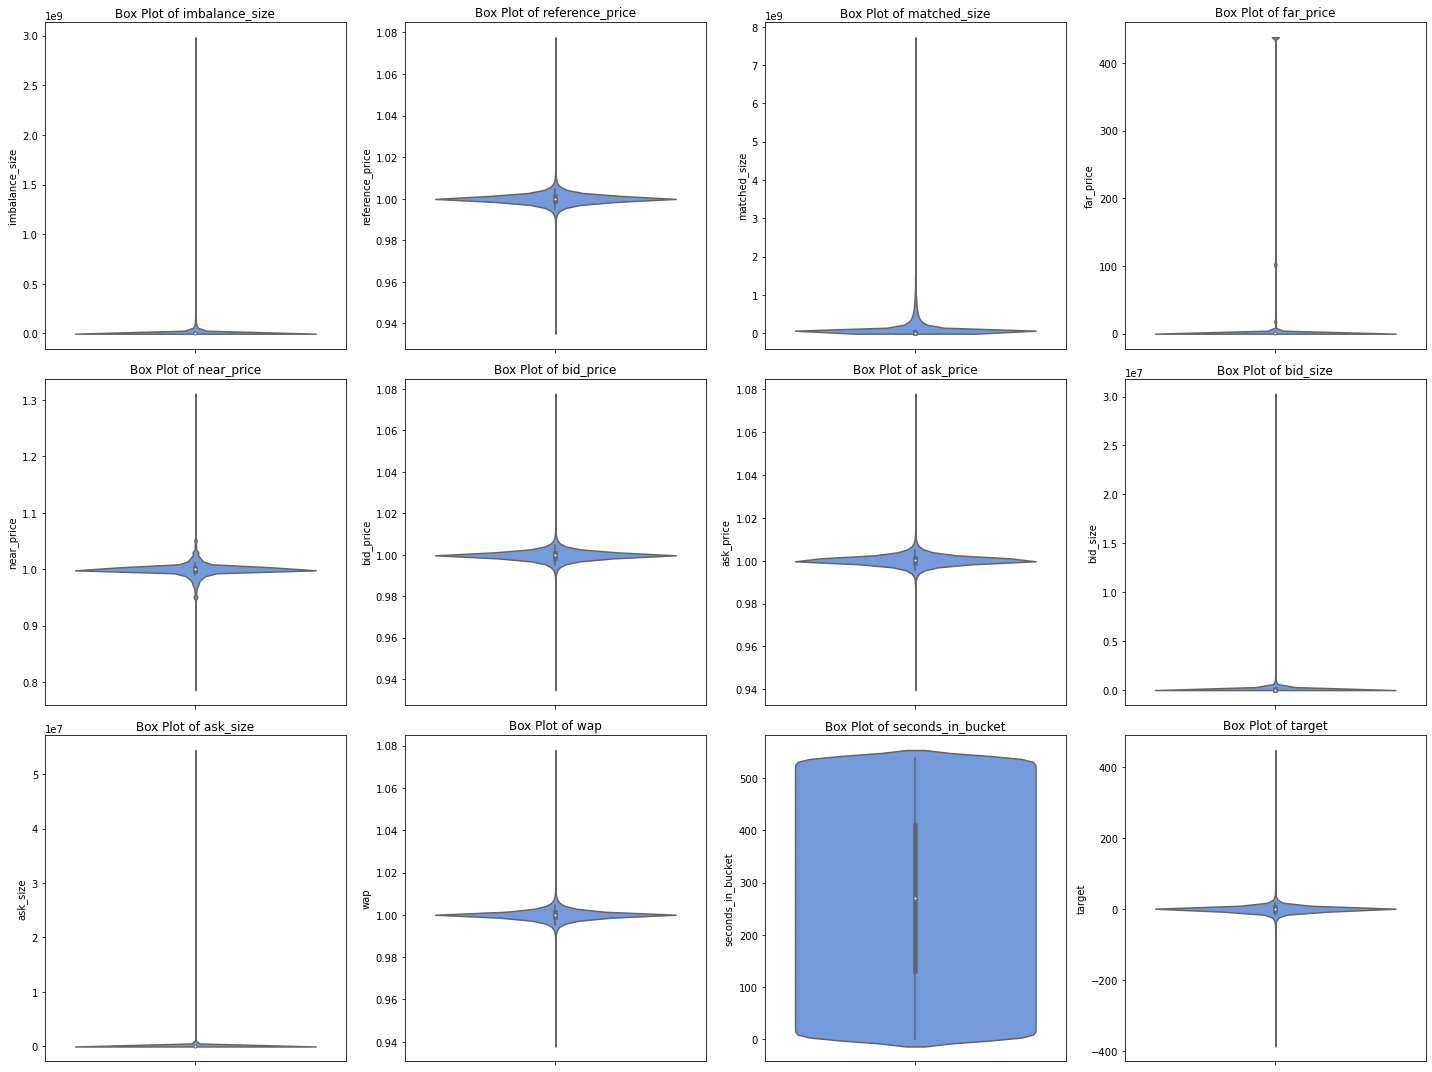

In [31]:
# Violin Plots
n_cols = 4
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for i, var in enumerate(numerical_cols):
    sns.violinplot(data=df, y=var, color=COLOR, ax=axes[i])
    axes[i].set_title(f'Violin Plot of {var}')
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

In [40]:
def three_iqr(df, columns, threshold):
    print('Method: 3IQR')
    outlier_counts = {}
    outlier_mask = pd.Series(data=False, index=df.index)
    initial_len = len(df)
    
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        column_outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
        outlier_mask = outlier_mask | column_outliers
        outlier_counts[column] = column_outliers.sum()
        print(f'Number of outliers in {column}: {outlier_counts[column]}')
    
    new_df = df[~outlier_mask]
    print(f'Total number of outliers is {initial_len - len(new_df)}')
    print(f'Share of outliers is {1 - (len(new_df) / initial_len):.2f}')
        
    return new_df

In [44]:
new_df = three_iqr(df, numerical_cols, 1.5).reset_index(drop=True)

Method: 3IQR
Number of outliers in imbalance_size: 619374
Number of outliers in reference_price: 320803
Number of outliers in matched_size: 637237
Number of outliers in far_price: 501784
Number of outliers in near_price: 379172
Number of outliers in bid_price: 324025
Number of outliers in ask_price: 321691
Number of outliers in bid_size: 509948
Number of outliers in ask_size: 505021
Number of outliers in wap: 325523
Number of outliers in seconds_in_bucket: 0
Number of outliers in target: 292263
Total number of outliers is 2290075
Share of outliers is 0.44


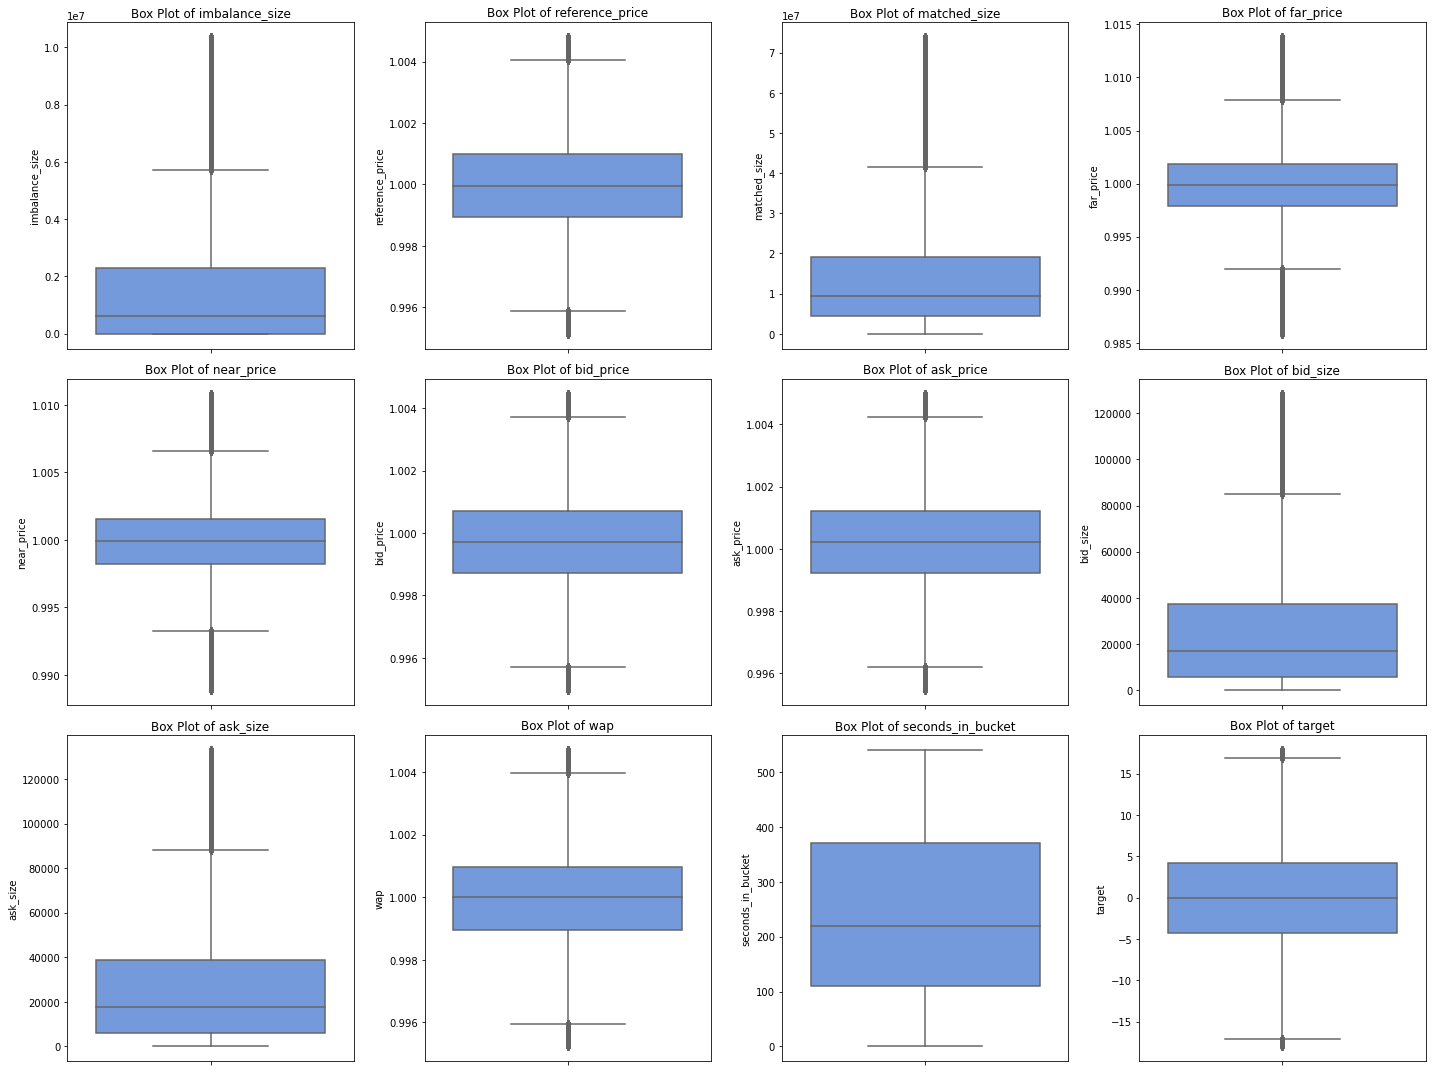

In [46]:
# Box Plots
n_cols = 4
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for i, var in enumerate(numerical_cols):
    sns.boxplot(data=new_df, y=var, color=COLOR, ax=axes[i])
    axes[i].set_title(f'Box Plot of {var}')
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

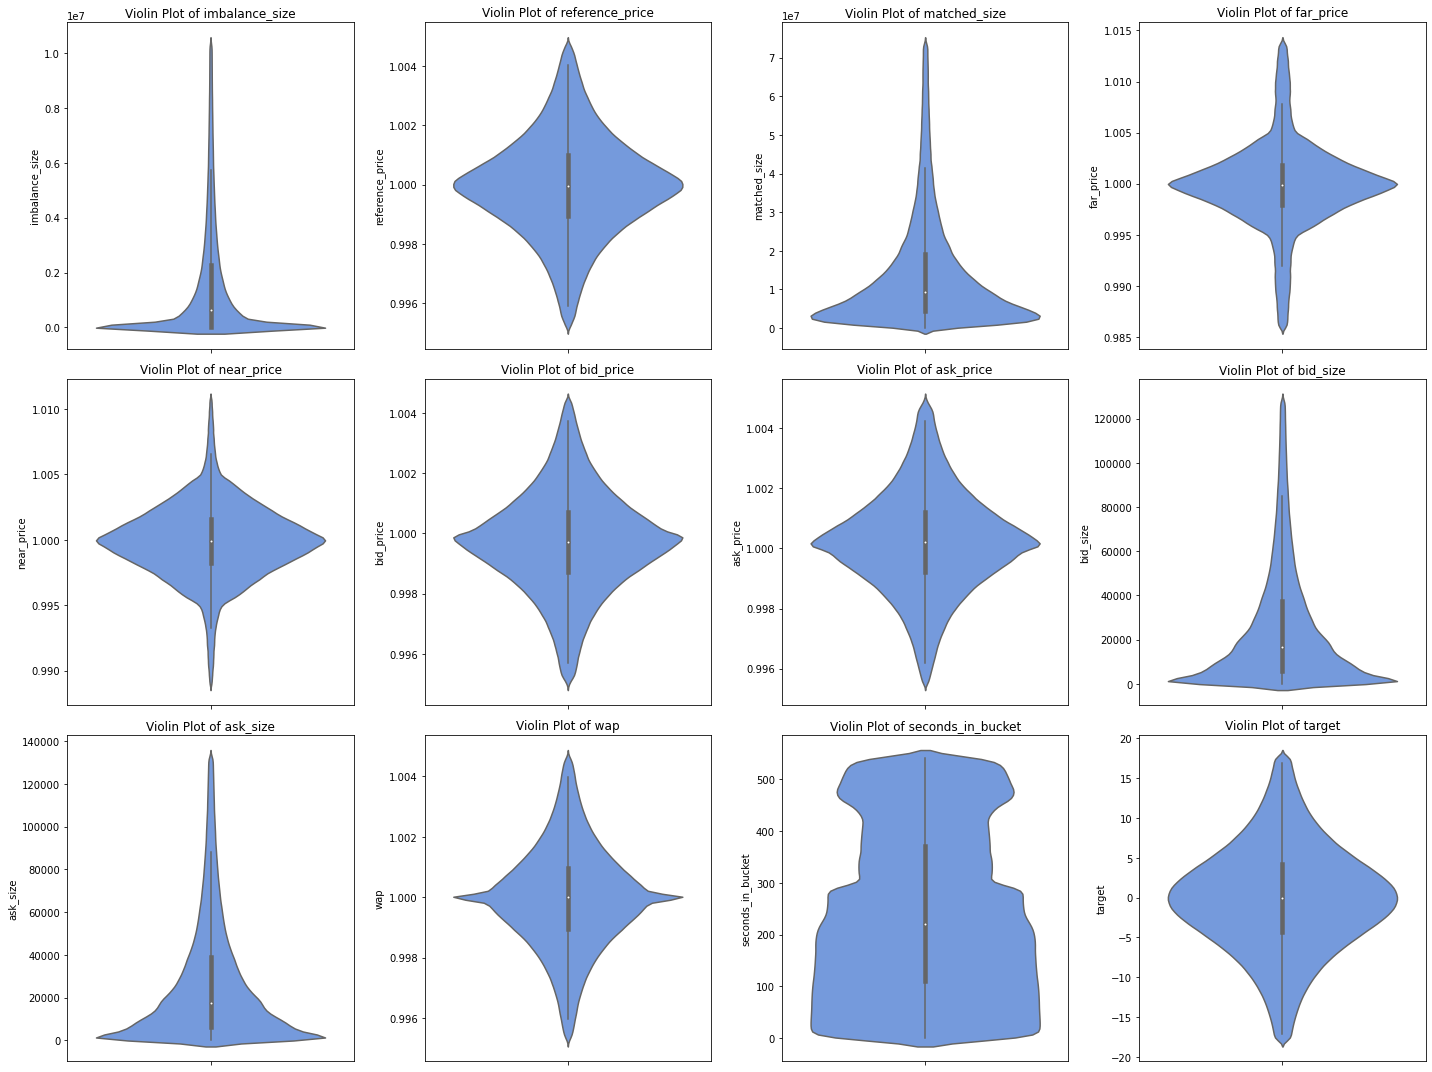

In [47]:
# Violin Plots
n_cols = 4
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for i, var in enumerate(numerical_cols):
    sns.violinplot(data=new_df, y=var, color=COLOR, ax=axes[i])
    axes[i].set_title(f'Violin Plot of {var}')
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

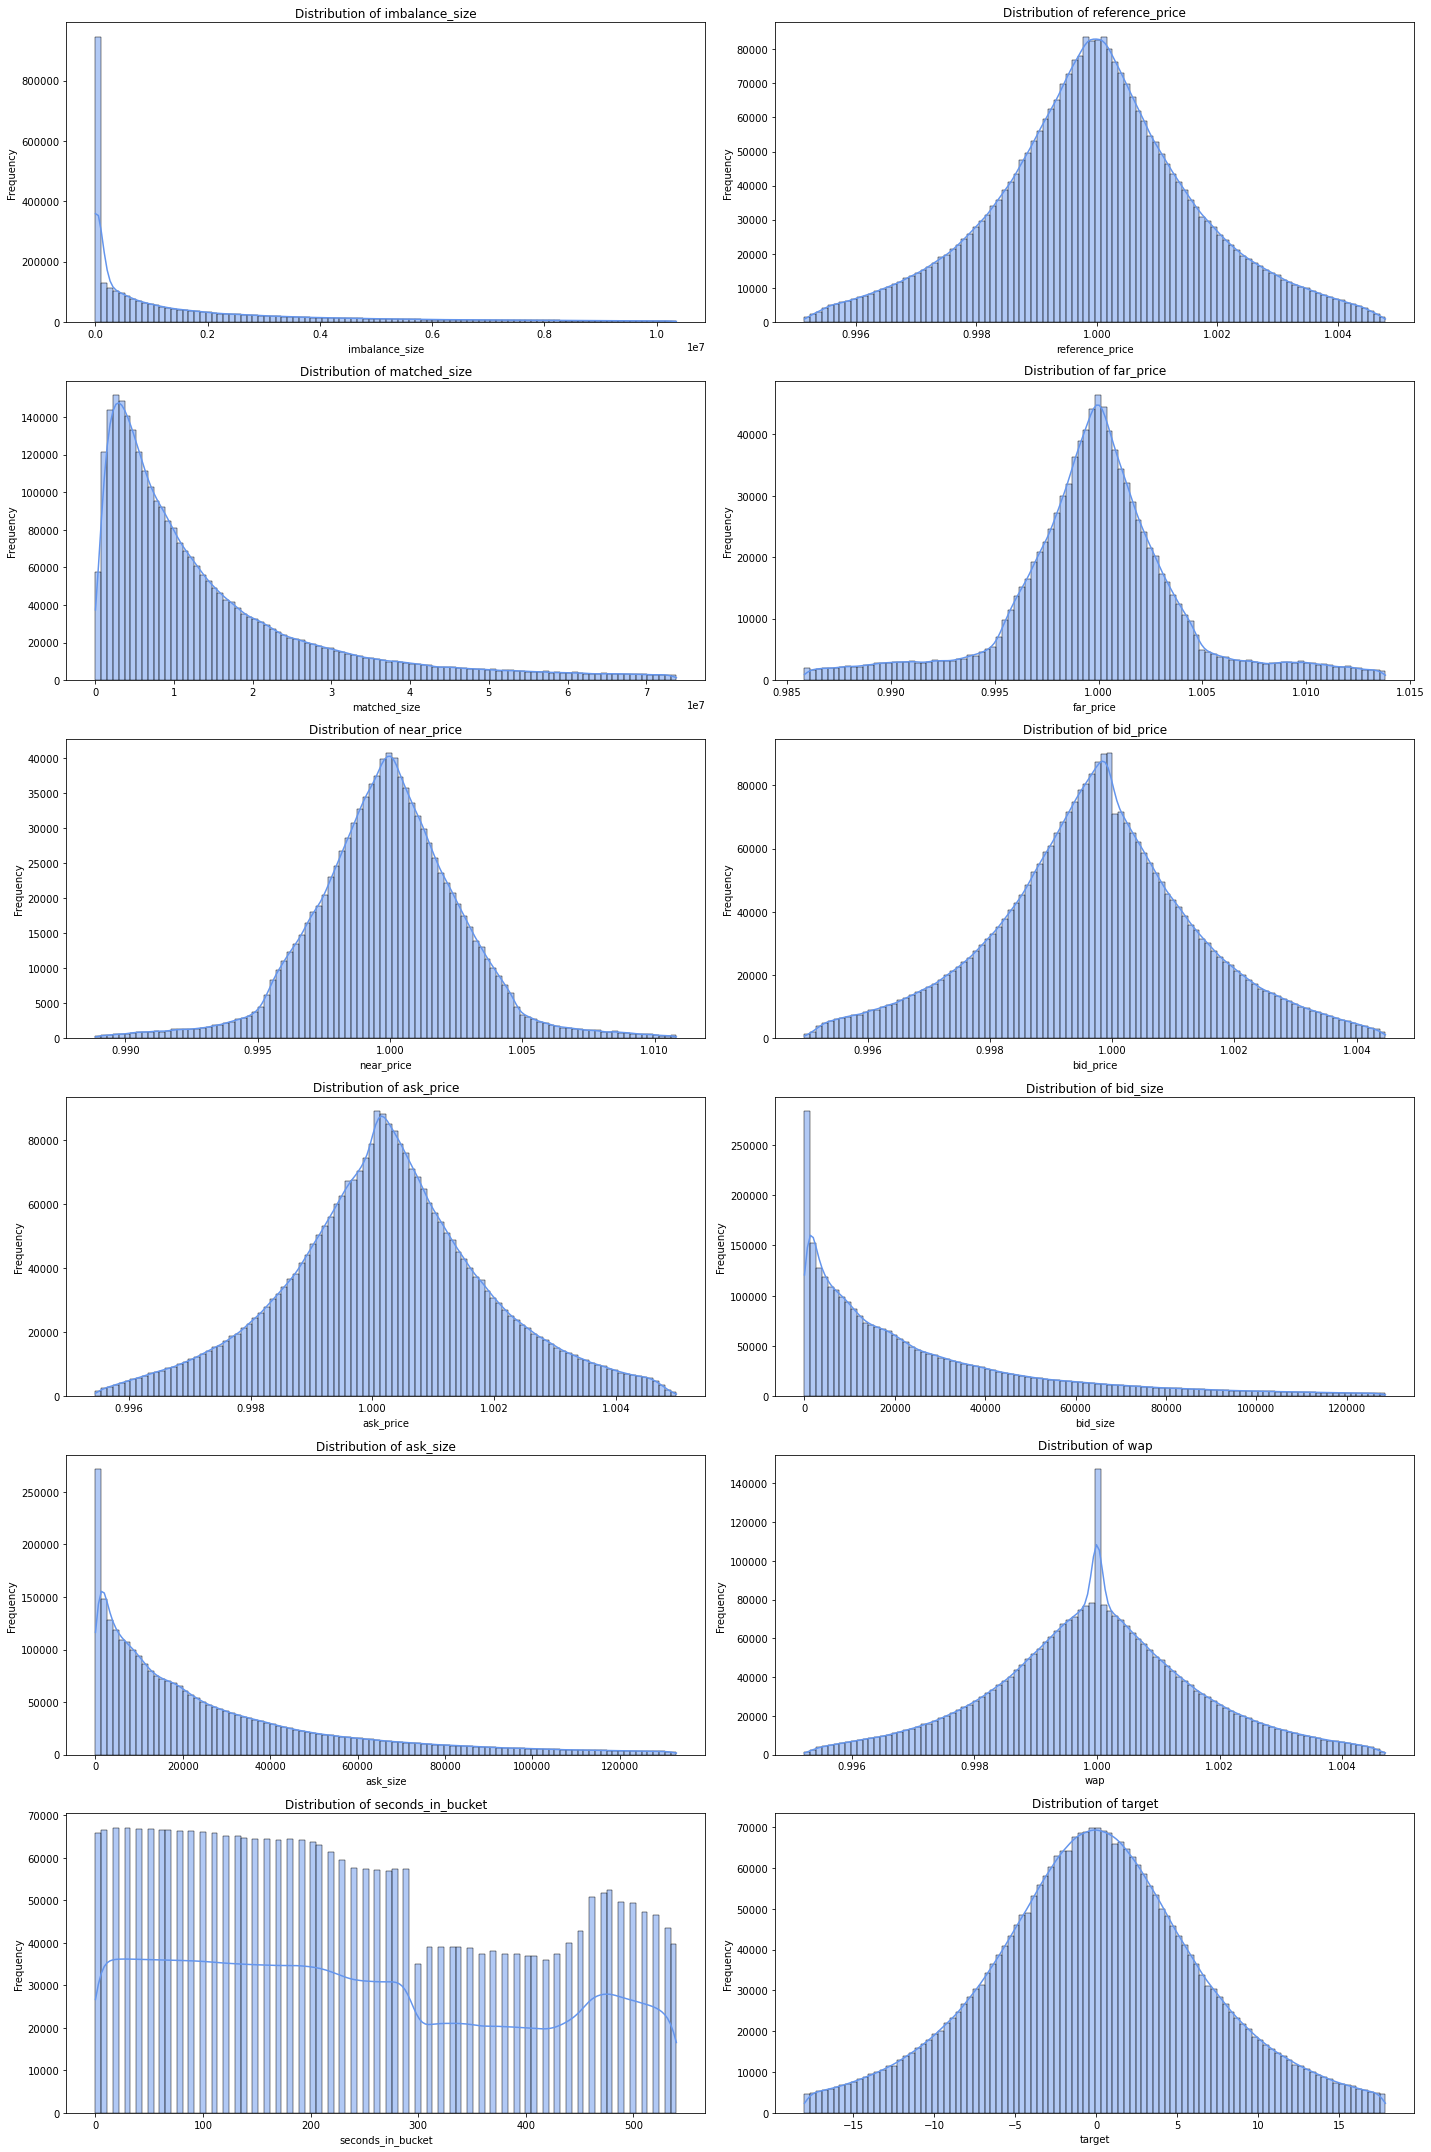

In [49]:
n_cols = 2
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for i, var in enumerate(numerical_cols):
    sns.histplot(new_df.sort_values(by=var, ascending=True)[var], bins=100, kde=True, color=COLOR, ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [22]:
df['far_price'][(~df['far_price'].isna()) & (df['far_price'] < 10)]

5730       1.000241
5731       0.981974
5732       1.000193
5733       1.003870
5734       1.007894
             ...   
5237975    0.999734
5237976    1.000129
5237977    0.995789
5237978    0.999210
5237979    1.000859
Name: far_price, Length: 2343599, dtype: float64

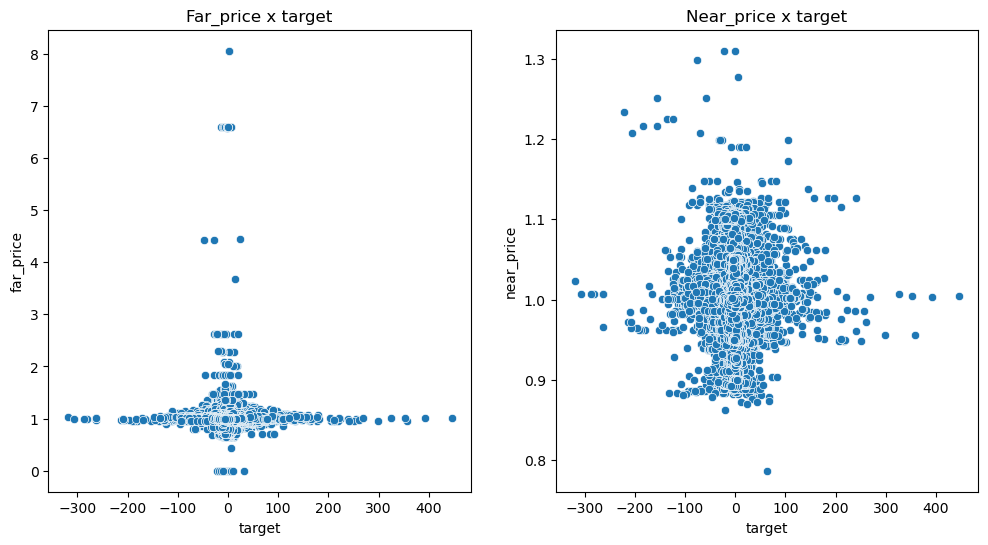

In [60]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

sns.scatterplot(x=df['target'][(~df['far_price'].isna()) & (df['far_price'] < 10)]\
                , y=df['far_price'][(~df['far_price'].isna()) & (df['far_price'] < 10)], ax=ax1)

sns.scatterplot(x=df['target'][(~df['near_price'].isna()) & (df['near_price'] < 10)]\
                , y=df['near_price'][(~df['near_price'].isna()) & (df['near_price'] < 10)], ax=ax2)

_ = ax1.set_title('Far_price x target')
_ = ax2.set_title('Near_price x target')

has no big correlation with the target, probably will remove later

In [54]:
lower_percentile = np.nanpercentile(df['target'], 2.5)
upper_percentile = np.nanpercentile(df['target'], 97.5)
upper_percentile

18.7397

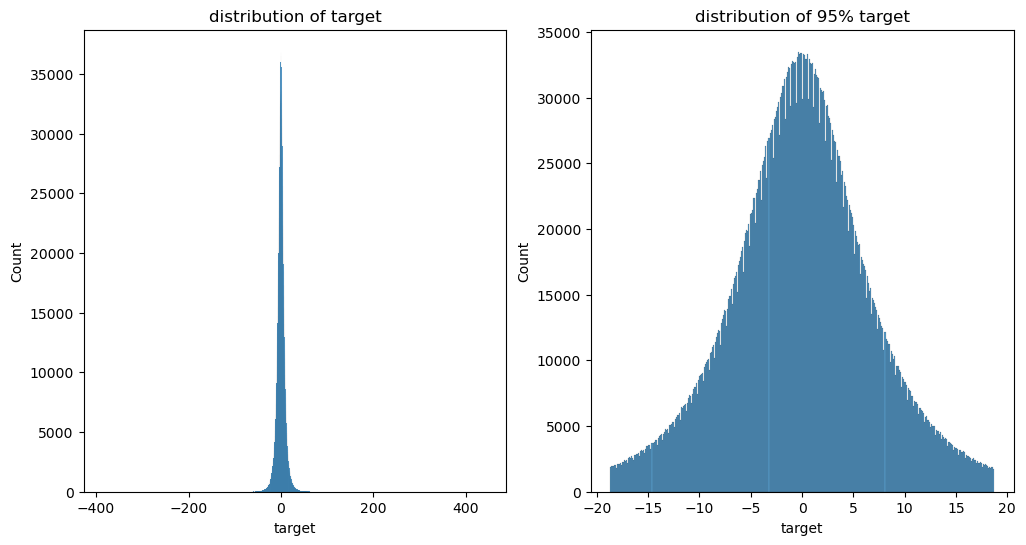

In [59]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

sns.histplot(x=df.target, ax=ax1)

# let's filter target by percentiles to better check distribution
lower_percentile = np.nanpercentile(df.target, 2.5)
upper_percentile = np.nanpercentile(df.target , 97.5)

filtered_target = df.query('target >= @lower_percentile and target <= @upper_percentile')

sns.histplot(x=filtered_target.target, ax=ax2)

_ = ax1.set_title('distribution of target')
_ = ax2.set_title('distribution of 95% target')


target is normaly distributed